# Kalman Filter
<font size="3">
    
<br>簡單理解 : 加入量測誤差後對下一個狀態位置的估計。用於含有不確定訊息的動態系統做出有根據的推測<br/>
<br>簡化公式 : $$ \hat X_k = K_k \cdot Z_k + ( 1 - K_k ) \cdot \hat X_{k-1}$$ <br/>
    
$$ \hat X_k : (Current\ Estimmation)\ k狀態下，對X的估計 $$
$$ K_k : (Kalman\ Gain)\ 卡爾曼增益 $$
$$ Z_k : (Measured\ Value)\ 真實量測值(有誤差) $$
$$ \hat X_{k-1} : (Last\ Estimmation)\ 上一個狀態的估計值 $$

***
## Step 1.
<font size="3">
    
假設系統動態模型 : 

$$ x_k = Ax_{k-1} + Bu_{k} + W_{k-1}$$
$$ z_k = Hx_{k} + v_{k} $$ <br>

$$ W_k\ 為過程噪音，假設其符合均值為\ 0\ ，協方差為\ Q\ 的常態分布$$
$$ Prediction\  Noise : W_k \sim N(0, Q_k) $$ 
$$ 同理\ v_k\ 為量測噪音$$
$$ Measurement\  Noise : v_k \sim N(0, R_k) $$ 
    
<font size="3">
    
 - A , B 和 H 均為參數，A 為系統變換模型，B 為輸入一控制模型，H 為觀察值對真實質的修正
    
 - 從系統動態模型可以得知矩陣 A , B 和 H 。他們很可能都是常數。

 - 第一個公式每個 x_k 可以通過一個線性隨機方程表示。任何一個 x_k 都是它 "前一狀態的值 x_{k-1}" 加上 "控制訊號 u_k "及 "噪音 W_{k−1}" 的線性组合。大多數情況下，並不需要控制訊號 u_k 。

 - 第二個公式告訴我們，任何量測值是當前狀態值及量測噪音的線性组合，假設噪音符合高斯分布。

***
## Step 2.
<font size="3"> 
    
(1) 首先計算推測值，再計算推測值與真實值之間的誤差共變異數矩陣 : 
    <br>新的最優估計 (x_k) 是根據上一最優估計 (x_{k-1}) 預測得到的，並加上已知外部控制量 (u_{k}) 的修正。
    <br>新的不確定性 (P_{k-1}) 由上一不確定性預測得到，並加上外部環境的干擾 (Q)。
$$ \hat x_k^- = A \hat x_{k-1} + B u_{k} \ \dots \ (1)$$ 
$$ \hat P_k^- = A P_{k-1} A^T + Q \ \dots \ (2)$$

(2)計算卡爾曼增益 K ，再計算估計值 : 
$$ K_k = P_k^- H^T ( H P_k^- H^T + R )^{-1} \ \dots \ (3)$$
$$ \hat x_k = \hat x_k^- +  K_k ( z_k - H \hat x_k^- ) \ \dots \ (4)$$

(3)最後計算估計值與真實值之間的誤差共變異數矩陣，為下次迭代做準備 : 
$$ P_k = ( I - K_k H) P_k^-  \ \dots \ (5)$$
    


![avatar](https://www.researchgate.net/publication/221844061/figure/fig3/AS:667214948618245@1536087848134/The-operation-of-the-Kalman-filter.png)

***
## Example 1 
### One Dimension Constant velocity motion 

> A car moves along an x axis. Velocity = 1 m/s

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
time = np.linspace(0, 49, 50)
v = 1
x = v * time # x_k = Ax_{k-1} + Bu_{k} + W_{k-1} 

<font size="3">

Gaussian Distribution: $$ f(x) = \frac {1}{\sqrt{2 \pi} \sigma} \exp { (- \frac {(x - \mu)^2}{2 \sigma ^2} )} $$

c:\python3.6\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


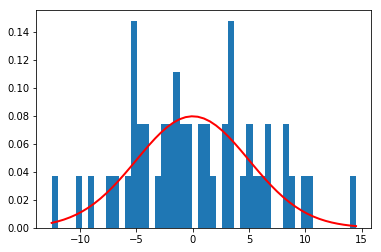

In [3]:
mu, R, size = 0, 5 ** 2 , time.shape[0]
R_sig = np.sqrt(R)
noise = np.random.normal(mu, R_sig, size)
count, bins, _ = plt.hist(noise, size, normed = True)
plt.plot(bins, 1. / (np.sqrt(2 * np.pi) * R_sig) * np.exp( - (bins - mu) ** 2 / (2 * R_sig ** 2)), lw = 2, c = 'r')
plt.show()

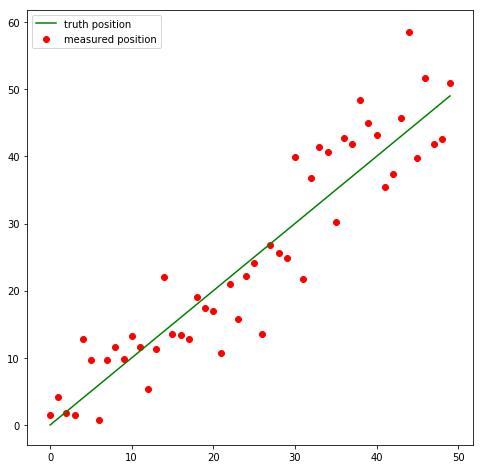

In [4]:
z = x + noise # 量測位置  z_k  = H * x_k-1 + Q_k 
plt.figure(figsize = (8, 8))
plt.plot(time, x, label = 'truth position', color = "g")
plt.scatter(time, z, label = 'measured position', color = "r")
plt.legend()
plt.show()

In [5]:
xhatminus = np.zeros(size) # prediction x
Pminus = np.zeros(size)    # prediction co-variance  
xhat = np.zeros(size)      # correction x
P = np.zeros(size)         # correction co-variance
K = np.zeros(size)         # Kalman Gain   
  
Q = 5**2 # estimate of measurement variance
P[0] = 1.0

In [6]:
for k in range(1,size):  
    # predict  
    xhatminus[k] = xhat[k - 1] + v * 1  # X_k = A X_{k-1} + BU_k, A=1, BU(k) = 0  
    Pminus[k] = P[k - 1] + Q      # P_k = A P_{k-1} A^T + Q_k ,A=1  
  
    # correct
    K[k] = Pminus[k] / ( Pminus[k] + R  ) # K_k = P_k H^T / [H P_k H^T + R ], H=1  
    xhat[k] = xhatminus[k] + K[k] * (z[k] - xhatminus[k]) # X_k = X_k + K_k [Z_k - H X_k], H=1  
    P[k] = (1 - K[k]) * Pminus[k] # P_k = (I - K_k H) P_k, H=1  

Text(0, 0.5, 'location')

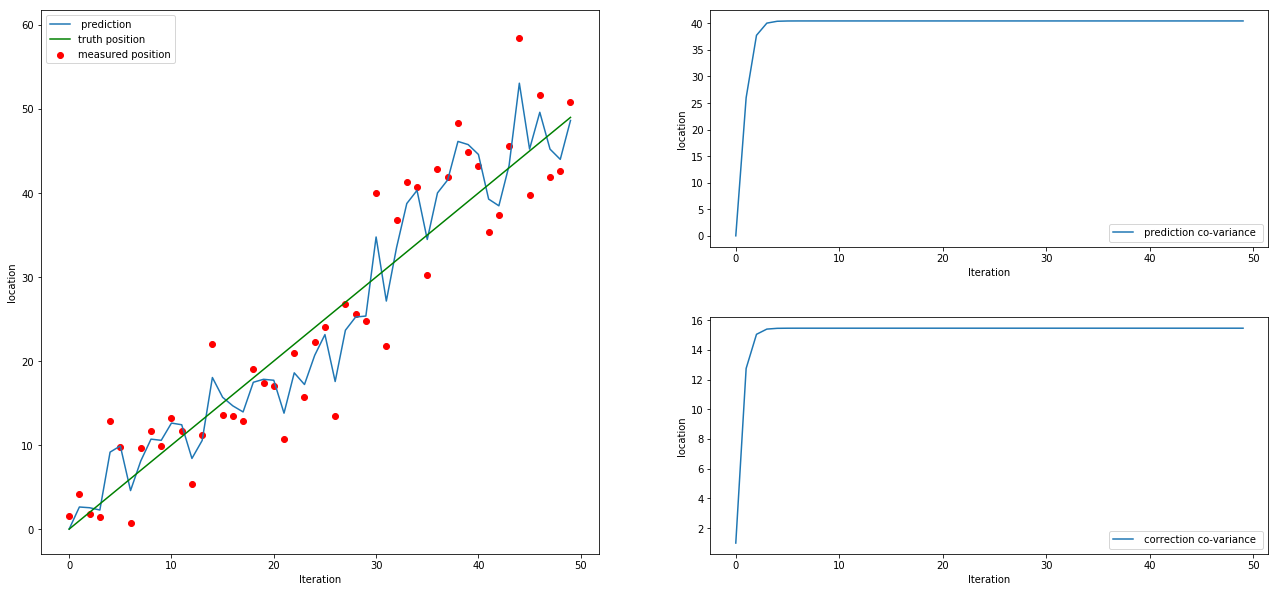

In [7]:
plt.figure(figsize = (22, 10)) 
ironman_grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.3)
plt.subplot(ironman_grid[:,0]) 
plt.plot(time, xhat, label=' prediction ')  #KF 濾波估計
plt.plot(time, x, label = 'truth position', color = "green")
plt.scatter(time, z, label = 'measured position', color = "red")
plt.legend()  
plt.xlabel('Iteration')  
plt.ylabel('location') 

plt.subplot(ironman_grid[0, 1]) 
plt.plot(time, Pminus, label=' prediction co-variance ') 
plt.legend()  
plt.xlabel('Iteration')  
plt.ylabel('location') 

plt.subplot(ironman_grid[1, 1]) 
plt.plot(time, P, label=' correction co-variance ')
plt.legend()  
plt.xlabel('Iteration')  
plt.ylabel('location')


## Example 2
### One Dimension Uniform Accelerated Motion

> A car moves along an x axis. Initial velocity = 0 m/s, acceleration = 1 m/s^2

In [8]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0, 49, 50) 
a = 1
x = (a * time**2)/2

In [9]:
mu, R, size = 0, 50 ** 2 , time.shape[0]
R_sig = np.sqrt(R)
noise = np.random.normal(mu, R_sig, size)

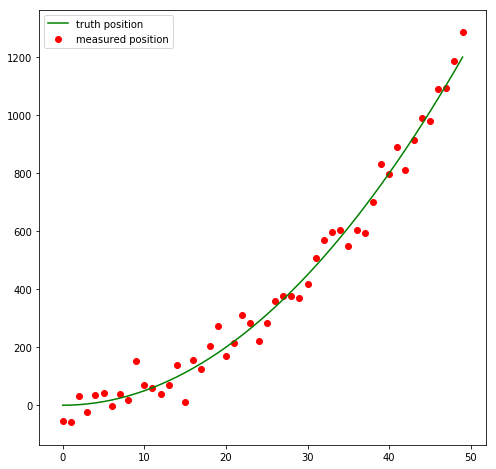

In [10]:
z = x + noise # 量測位置  z_k  = H * x_k-1 + Q_k 
plt.figure(figsize = (8, 8))
plt.plot(time, x, label = 'truth position', color = "g")
plt.scatter(time, z, label = 'measured position', color = "r")
plt.legend()
plt.show()

In [11]:
xhatminus = np.zeros(size) # prediction x
Pminus = np.zeros(size)    # prediction co-variance  
xhat = np.zeros(size)      # correction x
P = np.zeros(size)         # correction co-variance
K = np.zeros(size)         # Kalman Gain   
  
Q = 5**2 # estimate of measurement variance
P[0] = 10

In [12]:
for k in range(1,size):  
    # predict  
    xhatminus[k] = xhat[k - 1] + (xhat[k - 1] - xhat[k - 2]) + (a / 2) # X_k = A X_{k-1} + BU_k, A=1, BU(k) = 0  
    Pminus[k] = P[k - 1] + Q      # P_k = A P_{k-1} A^T + Q_k ,A=1  
  
    # correct
    K[k] = Pminus[k] / ( Pminus[k] + R  ) # K_k = P_k H^T / [H P_k H^T + R ], H=1  
    xhat[k] = xhatminus[k] + K[k] * (z[k] - xhatminus[k]) # X_k = X_k + K_k [Z_k - H X_k], H=1  
    P[k] = (1 - K[k]) * Pminus[k] # P_k = (I - K_k H) P_k, H=1  

Text(0, 0.5, 'location')

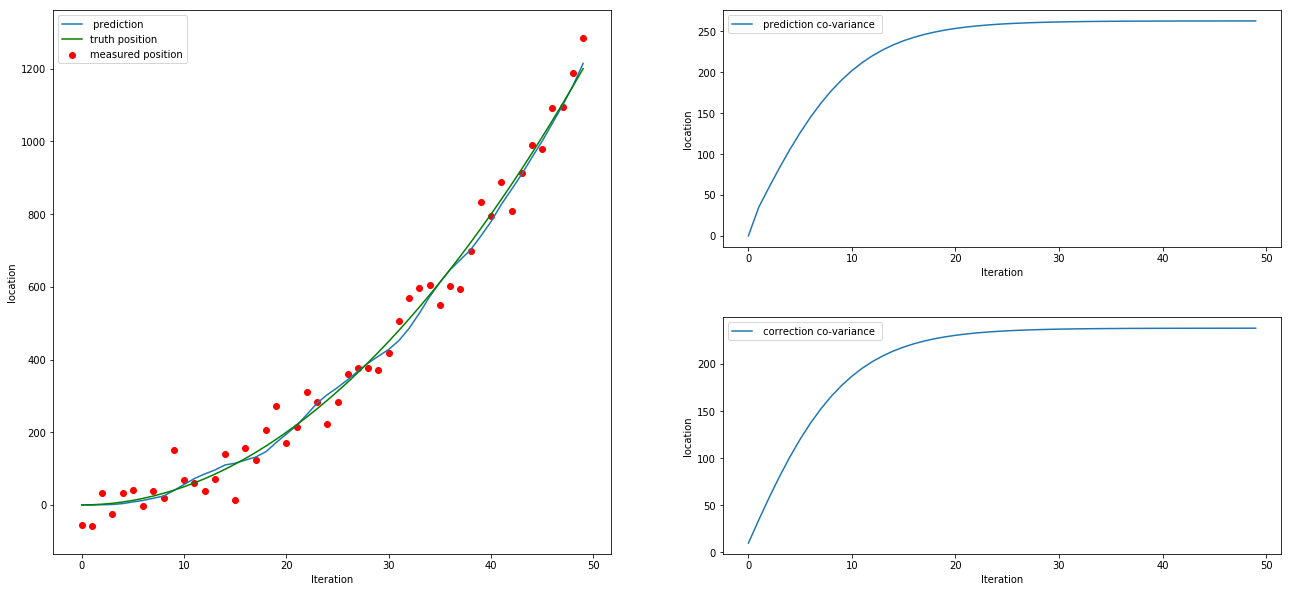

In [13]:
plt.figure(figsize = (22, 10)) 
ironman_grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.3)
plt.subplot(ironman_grid[:,0]) 
plt.plot(time, xhat, label=' prediction ')  #KF 濾波估計
plt.plot(time, x, label = 'truth position', color = "green")
plt.scatter(time, z, label = 'measured position', color = "red")
plt.legend()  
plt.xlabel('Iteration')  
plt.ylabel('location') 

plt.subplot(ironman_grid[0, 1]) 
plt.plot(time, Pminus, label=' prediction co-variance ') 
plt.legend()  
plt.xlabel('Iteration')  
plt.ylabel('location') 

plt.subplot(ironman_grid[1, 1]) 
plt.plot(time, P, label=' correction co-variance ')
plt.legend()  
plt.xlabel('Iteration')  
plt.ylabel('location')


## Example 3
### Mouse Tracking 
> cv2.KalmanFilter

In [16]:
import cv2
import numpy as np

frame = np.zeros((800,800,3),np.uint8)

last_measurement = current_measurement = np.array((2,1),np.float32)

last_predicition = current_prediction = np.zeros((2,1),np.float32)

def mousemove(event, x, y, s, p):

    global frame, current_measurement, measurements, last_measurement, current_prediction, last_prediction

    last_measurement = current_measurement
    last_prediction = current_prediction
    
    current_measurement = np.array([[np.float32(x)],[np.float32(y)]])
    
    # Kalman Filter --> correction
    kalman.correct(current_measurement)
    
    # kalman Filter --> Prediction
    current_prediction = kalman.predict()
    
    last_measured_x, last_measured_y = last_measurement[0],last_measurement[1]

    current_measured_x, current_measured_y = current_measurement[0],current_measurement[1]

    last_predict_x, last_predict_y = last_prediction[0],last_prediction[1]

    current_predict_x,current_predict_y = current_prediction[0],current_prediction[1]
    
    # Predict track（Red）
    cv2.line(frame, (last_predict_x, last_predict_y), (current_predict_x, current_measured_y),(0, 0, 250), 2)
    
    # measured track (Green)
    cv2.line(frame, (last_measured_x, last_measured_y), (current_measured_x, current_measured_y), (0, 100, 0), 2)

cv2.namedWindow("kalman_tracker")
cv2.setMouseCallback("kalman_tracker",mousemove)

kalman = cv2.KalmanFilter(4,2)

# measurement matrix
kalman.measurementMatrix = np.array([[1,0,0,0],[0,1,0,0]],np.float32)

# transition matrix 
kalman.transitionMatrix = np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]],np.float32)

# co-variance matrix (noise)
kalman.processNoiseCov = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],np.float32) * 0.03

while True:
    cv2.imshow("kalman_tracker",frame)
    if (cv2.waitKey(30) & 0xff) == 27:
        break

cv2.destroyAllWindows()

### citation :
 - https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf
 - https://www.itread01.com/content/1544735344.html
 - https://www.itread01.com/content/1544583261.html  (詳解卡爾曼濾波器)